In [3]:
import numpy as np
import copy
from tqdm import tqdm_notebook as tqdm, tnrange as trange
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def softmax(w):
    return np.exp(w) / np.sum(np.exp(w))

In [13]:
def get_first_reward(theta, phi):
    '''Retrieve the reward of the first player
    Input: theta, phi - logits characterizing player strategies
    '''
    p = softmax(theta)
    q = softmax(phi)
    # analytical expectation
    # paper beats rock, scissors beat paper, rock beats scissors
    exp = p[0]*q[1] - p[1]*q[0] + \
          p[1]*q[2] - p[2]*q[1] + \
          p[2]*q[0] - p[0]*q[2]
    return exp

def get_second_reward(theta, phi):
    return get_first_reward(phi, theta)

def get_first_loss(theta, phi):
    return -get_first_reward(theta, phi)

def get_second_loss(theta, phi):
    return -get_second_reward(theta, phi)

def get_simult(theta, phi):
    '''Simultaneous gradient of 2 losses
    '''
        #1: get_first_reward(phi+, theta) - get_first_reward(phi-, theta)
        
        #2: get_second_reward(theta+, phi) - get_second_reward(theta-, phi)
        # equivalent to
        # get_first_reward(phi, theta+) - get_first_reward(phi, theta-)
    eps = 1e-9
    f = get_first_loss
    # first-order gradient approximation
    theta_grad = np.zeros([3], dtype=np.float)
    phi_grad = np.zeros([3], dtype=np.float)
    for i in range(3):
        up = copy.deepcopy(theta)
        up[i] += 0.5*eps
        
        down = copy.deepcopy(theta)
        down[i] -= 0.5*eps
        
        theta_grad[i] = (f(up, phi) - f(down, phi)) / eps        
    for i in range(3):
        up = copy.deepcopy(phi)
        up[i] += 0.5*eps
        
        down = copy.deepcopy(phi)
        down[i] -= 0.5*eps
        
        # minus because (grad of second loss) is (-grad of first loss)
        phi_grad[i] = -((f(theta, up) - f(theta, down)) / eps)
    return theta_grad, phi_grad

# def get_grads(f1, f2, theta, phi):
#     theta_grad = numerical_grad(f1, theta, phi)
#     phi_grad = numerical_grad(f2, phi, theta)
#     return theta_grad, phi_grad

In [14]:
def get_pure_hess(f, theta, phi):
    eps = 1e-7
    hess = np.zeros([theta.shape[0],]*2)
    for i in range(hess.shape[0]):
        for j in range(hess.shape[1]):
            if i == j:
                up = copy.deepcopy(theta)
                up[i] += 0.5*eps
                down = copy.deepcopy(theta)
                down[i] -= 0.5*eps
                hess[i, i] = (f(up, phi) - 2*f(theta, phi) + f(down, phi)) / eps**2
            else:
                pure1 = copy.deepcopy(theta)
                pure1[i] += 0.5*eps
                pure1[j] += 0.5*eps
                pure2 = copy.deepcopy(theta)
                pure2[i] -= 0.5*eps
                pure2[j] -= 0.5*eps
                mixed1 = copy.deepcopy(theta)
                mixed1[i] += 0.5*eps
                mixed1[j] -= 0.5*eps
                mixed2 = copy.deepcopy(theta)
                mixed2[i] -= 0.5*eps
                mixed2[j] += 0.5*eps

                hess[i, j] = (f(pure1, phi) + f(pure2, phi) - f(mixed1, phi) - f(mixed2, phi)) / (4 * eps**2)
    return hess

def get_mixed_hess(f, theta, phi):
    eps = 1e-9
    hess = np.zeros([theta.shape[0],]*2)
    for i in range(hess.shape[0]):
        for j in range(hess.shape[1]):
            pure1 = copy.deepcopy([theta, phi])
            pure1[0][i] += 0.5*eps
            pure1[1][j] += 0.5*eps
            pure2 = copy.deepcopy([theta, phi])
            pure2[0][i] -= 0.5*eps
            pure2[1][j] -= 0.5*eps
            mixed1 = copy.deepcopy([theta, phi])
            mixed1[0][i] += 0.5*eps
            mixed1[1][j] -= 0.5*eps
            mixed2 = copy.deepcopy([theta, phi])
            mixed2[0][i] -= 0.5*eps
            mixed2[1][j] += 0.5*eps

            hess[i, j] = (f(*pure1) + f(*pure2) - f(*mixed1) - f(*mixed2)) / (4 * eps**2)
    return hess

In [15]:
def get_hess(get_first_reward, get_second_reward, theta, phi):
    upper = np.concatenate([get_pure_hess(get_first_reward, theta, phi),
                            get_mixed_hess(get_first_reward, theta, phi)], axis=1)
    lower = np.concatenate([get_mixed_hess(get_second_reward, theta, phi),
                            get_pure_hess(get_second_reward, theta, phi)], axis=1)
    hess = np.concatenate([upper, lower], axis=0)
    return hess

# Optimize the first strategy

In [47]:
theta = np.asarray([1, 0, 0], dtype=float)
phi = np.asarray([0, 0, 1], dtype=float)
rewards = []
thetas = []
iters = 10000
for i in trange(iters):
    theta_grad, phi_grad = get_simult(theta, phi)
    theta = theta - theta_grad * 0.1
    thetas.append(theta[0])
    rewards.append(get_first_reward(theta, phi))

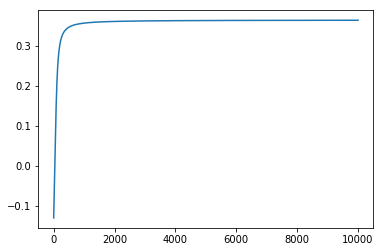

In [48]:
plt.plot(rewards)

Maximizes reward of the first player. Second one sleeps.

# Simultaneous gradient descent

In [16]:
theta = np.asarray([1, 0, 0], dtype=float)
phi = np.asarray([0, 0, 1], dtype=float)
losses = []
thetas = []
theta_grads = []
phi_grads = []
iters = 10000
lr = 0.1
for i in range(iters):
    theta_grad, phi_grad = get_simult(theta, phi)
    
    theta = theta - lr*theta_grad
    phi = phi - lr*phi_grad
    thetas.append(theta)
    theta_grads.append(theta_grad.tolist())
    phi_grads.append(phi_grad.tolist())
    losses.append(get_first_reward(theta, phi))

Text(0.5,0,'Iteration')

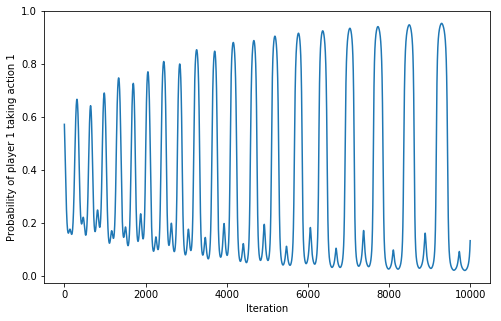

In [17]:
softmaxed = np.array([softmax(theta)[0] for theta in thetas])
plt.figure(figsize=(8, 5))
plt.plot(softmaxed)
plt.ylabel('Probability of player 1 taking action 1')
plt.xlabel('Iteration')

Text(0.5,0,'Iteration')

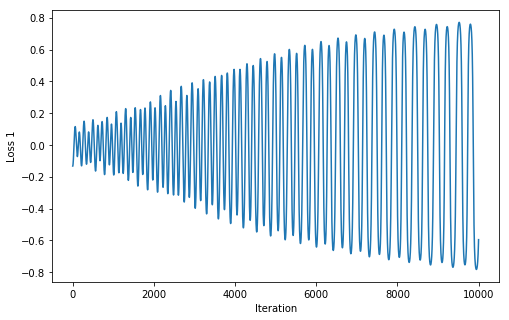

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.ylabel('Loss 1')
plt.xlabel('Iteration')

In [19]:
# also plot parameters
# and parameters+grads

In [20]:
xy =         [[
                 list(zip(*thetas))[1],
                 list(zip(*theta_grads))[1]
             ],
             [
                 list(zip(*theta_grads))[2],
                 list(zip(*theta_grads))[1]
             ],
             [
                 list(zip(*thetas))[1],
                 list(zip(*phi_grads))[1]
             ],
             [
                 list(zip(*thetas))[0],
                 list(zip(*phi_grads))[1]
             ],
             [
                 list(zip(*theta_grads))[0],
                 list(zip(*phi_grads))[1]
             ],
             [
                 list(zip(*theta_grads))[1],
                 list(zip(*phi_grads))[1]
             ],
             [
                 [np.linalg.norm(grad) for grad in theta_grads],
                 [np.linalg.norm(grad) for grad in phi_grads]
             ]]

In [23]:
# x, y = xy[1]
# plt.figure(figsize=(6, 6))
# plt.plot(x, y)

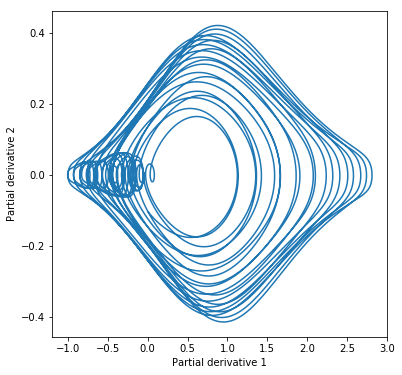

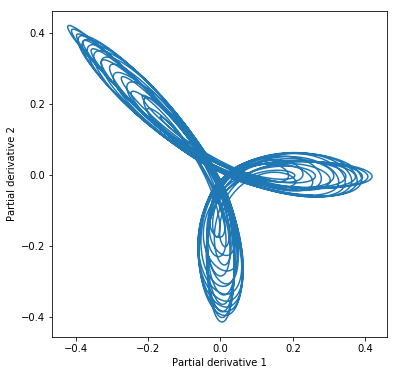

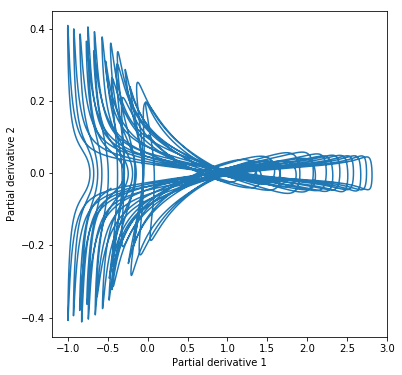

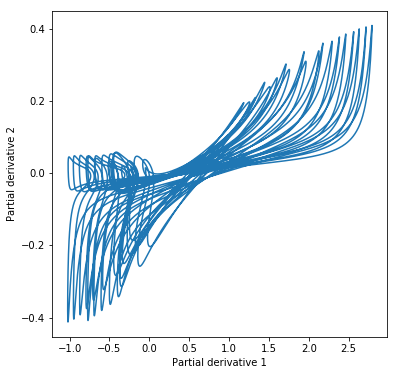

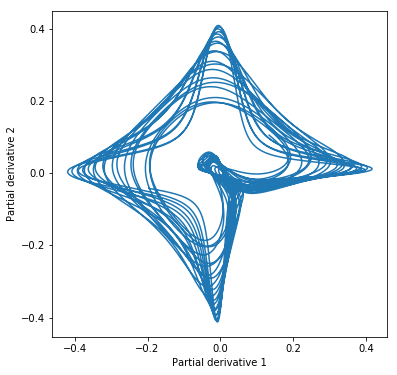

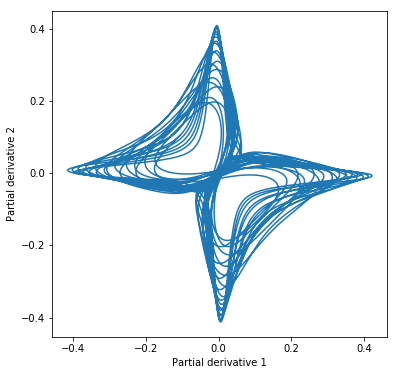

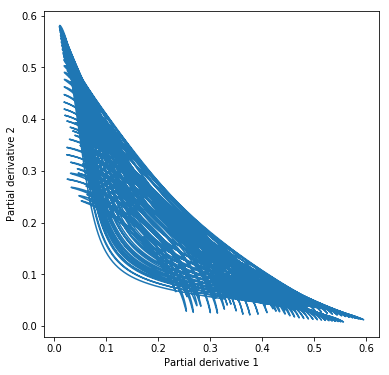

In [27]:
for x, y in xy:
#     plt.ylabel('Partial derivative 1')
#     plt.ylabel('Partial derivative 2')
    plt.figure(figsize=(6, 6))
    plt.plot(x, y)
    plt.xlabel('Partial derivative 1')
    plt.ylabel('Partial derivative 2')

In [ ]:
# plot this on grid w subplots

# Symplectic gradient adjustment

In [84]:
theta = np.asarray([1, 0, 0], dtype=float)
phi = np.asarray([0, 0, 1], dtype=float)
losses = []
thetas = []
theta_grads = []
phi_grads = []
iters = 100000
lr = 0.001
for i in range(iters):
    theta_grad, phi_grad = get_simult(theta, phi)
    
    hess = get_hess(get_first_loss, get_second_loss, theta, phi)
    a = (hess - hess.T) / 2  # antisymmetric comp
    adj = a.T @ np.concatenate([theta_grad, phi_grad])  # adjustment
    theta_grad += adj[:theta_grad.shape[0]]
    phi_grad += adj[theta_grad.shape[0]:]
    
    theta = theta - lr*theta_grad
    phi = phi - lr*phi_grad
    thetas.append(theta)
    theta_grads.append(theta_grad.tolist())
    phi_grads.append(phi_grad.tolist())
    losses.append(get_first_loss(theta, phi))

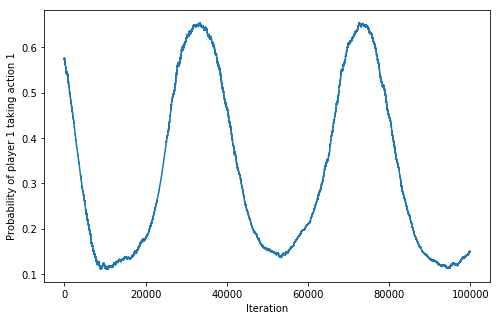

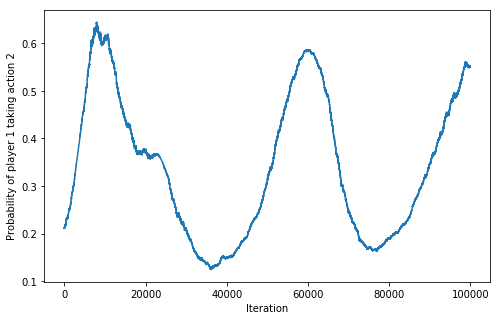

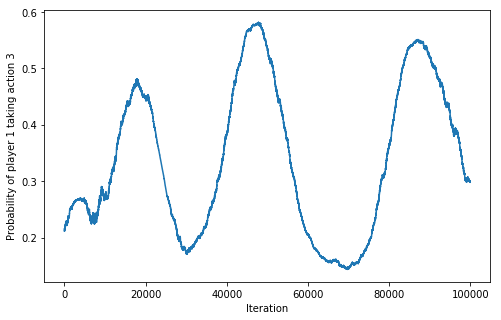

In [89]:
for i in range(3):
    softmaxed = np.array([softmax(theta)[i] for theta in thetas])
    plt.figure(figsize=(8, 5))
    plt.plot(softmaxed)
    plt.ylabel(f'Probability of player 1 taking action {i+1}')
    plt.xlabel('Iteration')

(-1, 1)

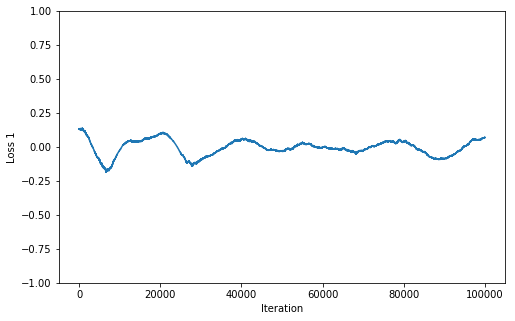

In [87]:
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.ylabel('Loss 1')
plt.xlabel('Iteration')
plt.ylim(-1, 1)

In [77]:
xy =         [[
                 list(zip(*thetas))[1],
                 list(zip(*theta_grads))[1]
             ],
             [
                 list(zip(*theta_grads))[2],
                 list(zip(*theta_grads))[1]
             ],
             [
                 list(zip(*thetas))[1],
                 list(zip(*phi_grads))[1]
             ],
             [
                 list(zip(*thetas))[0],
                 list(zip(*phi_grads))[1]
             ],
             [
                 list(zip(*theta_grads))[0],
                 list(zip(*phi_grads))[1]
             ],
             [
                 list(zip(*theta_grads))[1],
                 list(zip(*phi_grads))[1]
             ],
             [
                 [np.linalg.norm(grad) for grad in theta_grads],
                 [np.linalg.norm(grad) for grad in phi_grads]
             ]]

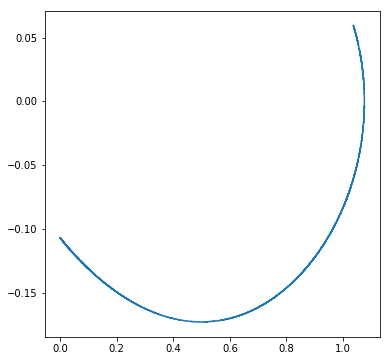

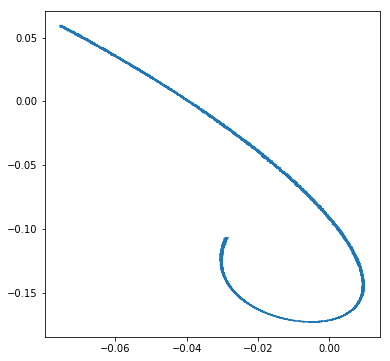

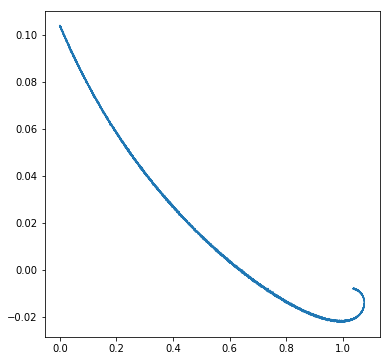

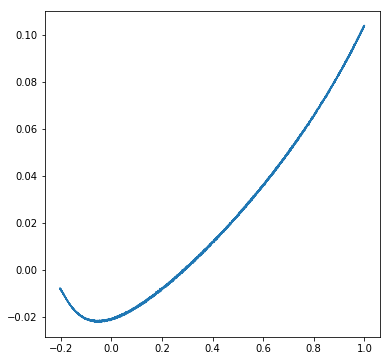

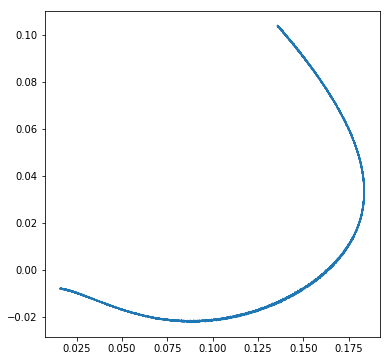

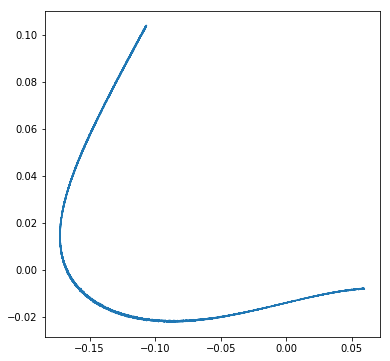

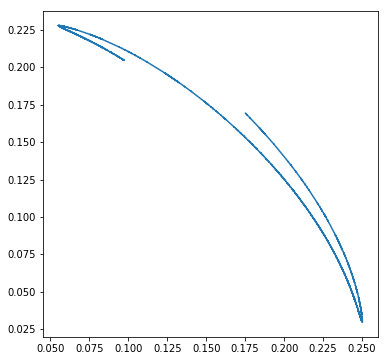

In [88]:
for x, y in xy:
    plt.figure(figsize=(6, 6))
    plt.plot(x, y)